## 1. Setup and Check GPU

In [1]:
import tensorflow as tf
import os

print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU ENABLED: {len(gpus)} GPU(s) detected")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("\nRunning on CPU")

TensorFlow version: 2.20.0

Running on CPU


## 2. Import Required Libraries

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pickle import load

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import concatenate, multiply, BatchNormalization

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Mount Google Drive

In [6]:
# LOCAL PATH CONFIGURATION (for Windows)
# Path to your saved models (adjust as needed)
models_path = r'path to your models'
models_path1 = r'path where tokenizer is at'

# Verify path exists
import os
if os.path.exists(models_path):
    print(f"✓ Models directory found: {models_path}")
    model_files = [f for f in os.listdir(models_path) if f.endswith('.keras')]
    print(f"  Found {len(model_files)} model files")
else:
    print(f"⚠ Models directory not found: {models_path}")
    print("  Please update the path above to point to your trained models")

# FOR GOOGLE COLAB (uncomment if using Colab):
# from google.colab import drive
# drive.mount('/content/drive')
# models_path = '/content/drive/MyDrive/image_captioning_models'

✓ Models directory found: C:\Users\jebar\OneDrive\Bureau\Deep Learning\Image Captioning\models
  Found 20 model files


## 4. Load Tokenizer

In [17]:
# Load the tokenizer
tokenizer_path = os.path.join(models_path1, 'tokenizer.pkl')
tokenizer = load(open(tokenizer_path, 'rb'))

vocab_size = len(tokenizer.word_index) + 1
max_length = 35  # Same as training

print(f"Tokenizer loaded successfully!")
print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_length}")

Tokenizer loaded successfully!
Vocabulary size: 7318
Max sequence length: 35


## 5. Define Model Architecture

In [18]:
def define_model(vocab_size, max_length):
    """Define the ENHANCED model architecture (same as training with gating mechanism)"""
    # Image feature input - Deeper processing with residual connection
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dense(512, activation='relu')(inputs1)
    fe2 = BatchNormalization()(fe1)
    fe3 = Dropout(0.4)(fe2)
    fe4 = Dense(512, activation='relu')(fe3)
    fe5 = BatchNormalization()(fe4)
    # Residual connection
    fe_residual = add([fe1, fe4])
    fe6 = Dense(256, activation='relu')(fe_residual)
    
    # Sequence input - Deeper LSTM with more capacity
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    # First LSTM layer with return_sequences
    se3 = LSTM(512, return_sequences=True, recurrent_dropout=0.2)(se2)
    se4 = BatchNormalization()(se3)
    # Second LSTM layer
    se5 = LSTM(512, return_sequences=False, recurrent_dropout=0.2)(se4)
    se6 = BatchNormalization()(se5)
    se7 = Dense(256, activation='relu')(se6)
    
    # Advanced decoder with gating mechanism (attention-like)
    # Create a gating vector to weight image and text features
    combined = concatenate([fe6, se7])
    
    # Gating mechanism - learns to balance image vs text importance
    gate = Dense(256, activation='sigmoid', name='gate')(combined)
    gated_image = multiply([fe6, gate])
    gated_text = multiply([se7, gate])
    
    # Combine gated features
    decoder1 = concatenate([gated_image, gated_text])
    decoder2 = Dense(512, activation='relu')(decoder1)
    decoder3 = BatchNormalization()(decoder2)
    decoder4 = Dropout(0.5)(decoder3)
    decoder5 = Dense(512, activation='relu')(decoder4)
    decoder6 = BatchNormalization()(decoder5)
    decoder7 = Dropout(0.5)(decoder6)
    decoder8 = Dense(256, activation='relu')(decoder7)
    outputs = Dense(vocab_size, activation='softmax')(decoder8)
    
    # Create model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

print("Enhanced model architecture defined (compatible with training)!")

Enhanced model architecture defined (compatible with training)!


## 6. Load Trained Model

In [19]:
# Load Model from Epoch 18
print("="*60)
print("Loading Model from Epoch 18")
print("="*60)

# Specify the model file for epoch 18
model_file = os.path.join(models_path, 'model_epoch_18.keras')

try:
    if os.path.exists(model_file):
        # Option 1: Try loading complete model directly
        try:
            model = load_model(model_file)
            print(f"✓ Complete model loaded from: {model_file}")
        except Exception as e:
            print(f"Cannot load complete model, loading weights instead...")
            print(f"  Error: {e}")
            # Option 2: Load weights into architecture
            model = define_model(vocab_size, max_length)
            model.load_weights(model_file)
            print(f"✓ Model weights loaded from: {model_file}")
    else:
        print(f"⚠ Model file not found: {model_file}")
        print("\nAvailable model files:")
        if os.path.exists(models_path):
            for f in sorted(os.listdir(models_path)):
                if f.endswith('.keras'):
                    print(f"  • {f}")
        raise FileNotFoundError(f"Model epoch 18 not found at {model_file}")
    
    print("\n✓ Model ready for inference!")
    print(f"  Model architecture: Enhanced (with gating mechanism)")
    print(f"  Training epoch: 18")
    
except Exception as e:
    print(f"\n⚠ Error loading model: {e}")
    print("\nTroubleshooting:")
    print("1. Check if the model file exists")
    print("2. Verify the models_path is correct")
    print("3. Ensure the model was saved during training")

Loading Model from Epoch 18
✓ Complete model loaded from: C:\Users\jebar\OneDrive\Bureau\Deep Learning\Image Captioning\models\model_epoch_18.keras

✓ Model ready for inference!
  Model architecture: Enhanced (with gating mechanism)
  Training epoch: 18


## 6.1 Verify Model Architecture

In [20]:
# Verify the model architecture and summary
print("\n" + "="*60)
print("Model Architecture Summary")
print("="*60)
print(model.summary())

# Count parameters
total_params = model.count_params()
print(f"\n✓ Total parameters: {total_params:,}")

# Verify key layers exist (for enhanced architecture)
layer_names = [layer.name for layer in model.layers]
print(f"\n✓ Total layers: {len(layer_names)}")

# Check for gating mechanism
if 'gate' in layer_names:
    print("✓ Gating mechanism detected (Enhanced model)")
else:
    print("⚠ No gating layer found (may be baseline model)")

print("\nModel is ready for testing!")


Model Architecture Summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)          │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_1 (InputLayer)          │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 35, 256)           │       1,873,408 │ input_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │       1,049,088 │ input_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 35, 256)           │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 35)                │               0 │ input_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 35, 512)           │       1,574,912 │ dropout_1[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 35, 512)           │           2,048 │ lstm[0][0],                │
│ (BatchNormalization)          │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 512)               │         262,656 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 512)               │       2,099,200 │ batch_normalization_6[0][… │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_12 (Add)                  │ (None, 512)               │               0 │ dense[0][0], dense_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 512)               │           2,048 │ lstm_1[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 256)               │         131,32

 Total params: 29,392,324 (112.12 MB)

 Trainable params: 9,795,734 (37.37 MB)

 Non-trainable params: 5,120 (20.00 KB)

 Optimizer params: 19,591,470 (74.74 MB)

None

✓ Total parameters: 9,800,854

✓ Total layers: 28
✓ Gating mechanism detected (Enhanced model)

Model is ready for testing!


## 7. Load Xception for Feature Extraction

In [21]:
# Load Xception model for extracting features from test images
xception_model = Xception(include_top=False, pooling='avg', weights='imagenet')
print("Xception model loaded for feature extraction!")

Xception model loaded for feature extraction!


## 8. Feature Extraction Function

In [22]:
def extract_features(image_path, model):
    """Extract features from an image using Xception"""
    try:
        # Load and preprocess image
        image = Image.open(image_path)
        image = image.resize((299, 299))
        image = np.array(image)
        
        # Handle different image formats
        if len(image.shape) == 2:  # Grayscale
            image = np.stack([image] * 3, axis=-1)
        elif image.shape[2] == 4:  # RGBA
            image = image[:, :, :3]
        
        # Preprocess for Xception
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        # Extract features
        features = model.predict(image, verbose=0)
        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

print("Feature extraction function defined!")

Feature extraction function defined!


## 9. Caption Generation Functions

In [23]:
def word_for_id(integer, tokenizer):
    """Map an integer to a word"""
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(model, tokenizer, photo, max_length):
    """Generate a caption for an image (compatible with enhanced training)"""
    in_text = 'start'
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # CRITICAL: Use padding='post' for right-padding (same as training)
        # This is required for GPU-accelerated LSTM (cuDNN) compatibility
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        
        # Predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        # Map integer to word
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        
        # Append word to input sequence
        in_text += ' ' + word
        
        # Stop if end token
        if word == 'end':
            break
    
    # Remove start and end tokens
    caption = in_text.replace('start', '').replace('end', '').strip()
    return caption

print("Caption generation functions defined (with padding='post' for compatibility)!")

Caption generation functions defined (with padding='post' for compatibility)!


## 10. Inference Function with Visualization

In [24]:
def predict_caption(image_path, display=True):
    """Generate and display caption for an image"""
    # Extract features
    photo_features = extract_features(image_path, xception_model)
    
    if photo_features is None:
        print("Failed to extract features")
        return None
    
    # Generate caption
    caption = generate_caption(model, tokenizer, photo_features, max_length)
    
    # Display results
    if display:
        img = Image.open(image_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Generated Caption:\n{caption}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
    
    return caption

print("Inference function ready!")

Inference function ready!


## 10.1 Quick Test - Single Image

Use this cell for quick testing with a single image path

Testing with Epoch 18 Model
Image: 667626_18933d713e.jpg



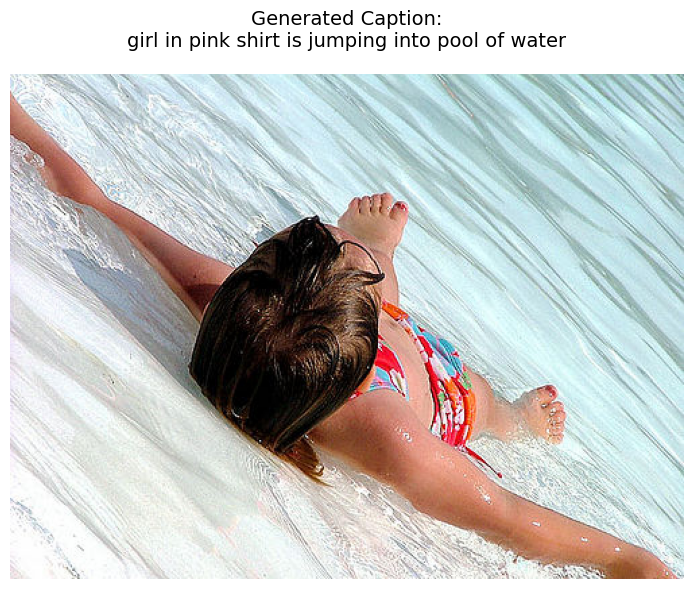


Generated Caption: girl in pink shirt is jumping into pool of water


In [25]:
# Quick Test - Update the path to your test image
# Example path format for Windows: r'C:\Users\jebar\Pictures\test_image.jpg'

# OPTION 1: Test with a specific image
test_image_path = r'path to dataset...\667626_18933d713e.jpg'

# OPTION 2: Or pick a random image from the dataset
# import random
# dataset_dir = r'C:\Users\jebar\OneDrive\Bureau\Deep Learning\Flickr8k\Flicker8k_Dataset'
# images = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]
# test_image_path = os.path.join(dataset_dir, random.choice(images))

# Test the image
if os.path.exists(test_image_path):
    print(f"Testing with Epoch 18 Model")
    print(f"Image: {os.path.basename(test_image_path)}")
    print("="*60 + "\n")
    
    caption = predict_caption(test_image_path, display=True)
    print(f"\n{'='*60}")
    print(f"Generated Caption: {caption}")
    print("="*60)
else:
    print(f"⚠ Image not found: {test_image_path}")
    print("\nPlease update the 'test_image_path' variable above with a valid image path")

## 11. Upload and Test an Image

In [ ]:
# FOR GOOGLE COLAB: Upload an image
# Uncomment the lines below if using Google Colab

"""
from google.colab import files

print("Upload an image to generate a caption:")
uploaded = files.upload()

# Get the uploaded filename
for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")
    caption = predict_caption(filename)
    print(f"\nGenerated Caption: {caption}")
"""

# FOR LOCAL USE: Test with a local image file
# Update the path to your test image
print("For local testing, update the image path below:")
print("Example:")
print("  test_image = r'C:\\Users\\jebar\\OneDrive\\Bureau\\Deep Learning\\test_image.jpg'")
print("  caption = predict_caption(test_image)")
print("\nOr use the cell below to test multiple images from a directory")

## 12. Test on Multiple Images

Found 8091 test images

Testing with Model from Epoch 18


Image: 101654506_8eb26cfb60.jpg


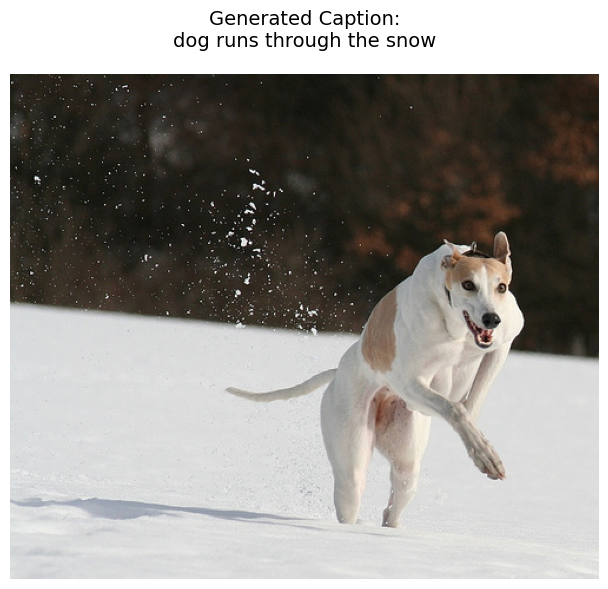

Generated Caption: dog runs through the snow

Image: 101669240_b2d3e7f17b.jpg


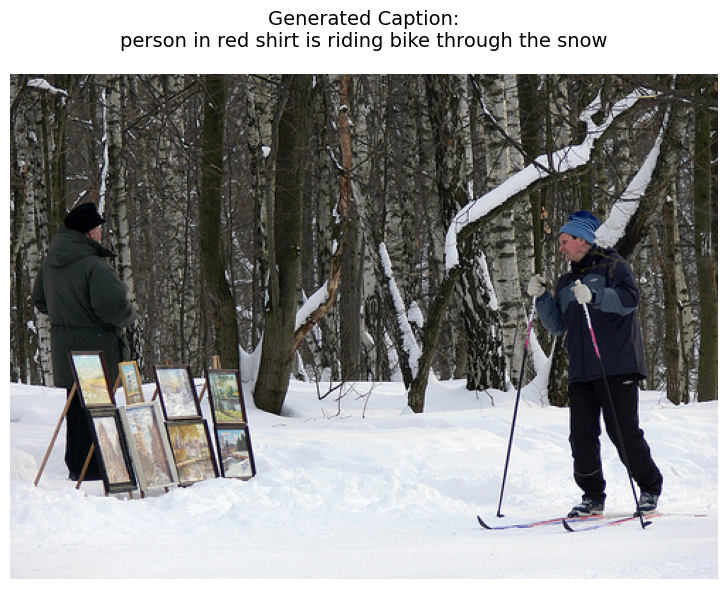

Generated Caption: person in red shirt is riding bike through the snow

Image: 1016887272_03199f49c4.jpg


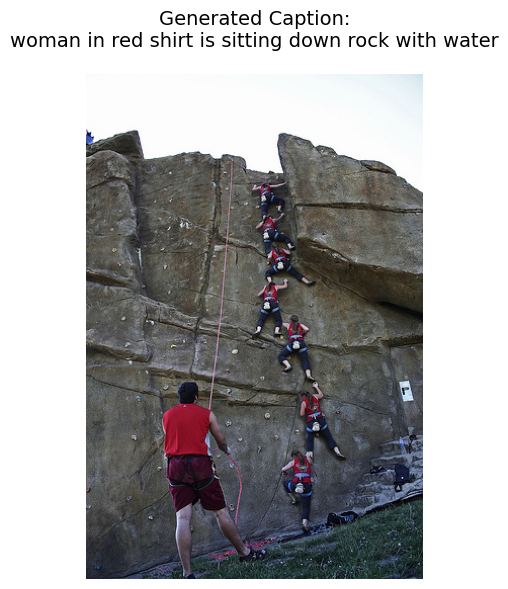

Generated Caption: woman in red shirt is sitting down rock with water

Image: 1019077836_6fc9b15408.jpg


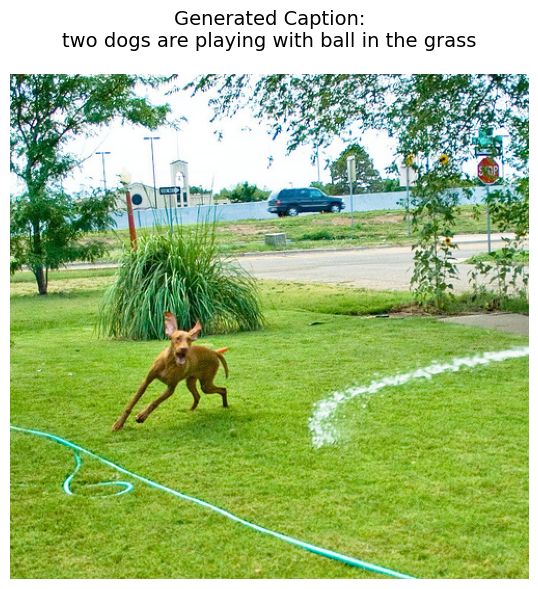

Generated Caption: two dogs are playing with ball in the grass

Image: 1019604187_d087bf9a5f.jpg


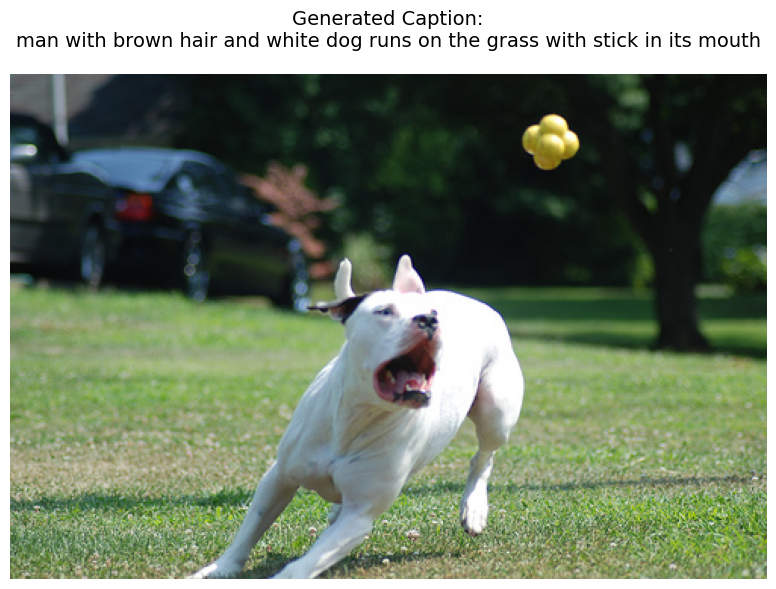

Generated Caption: man with brown hair and white dog runs on the grass with stick in its mouth

Image: 1020651753_06077ec457.jpg


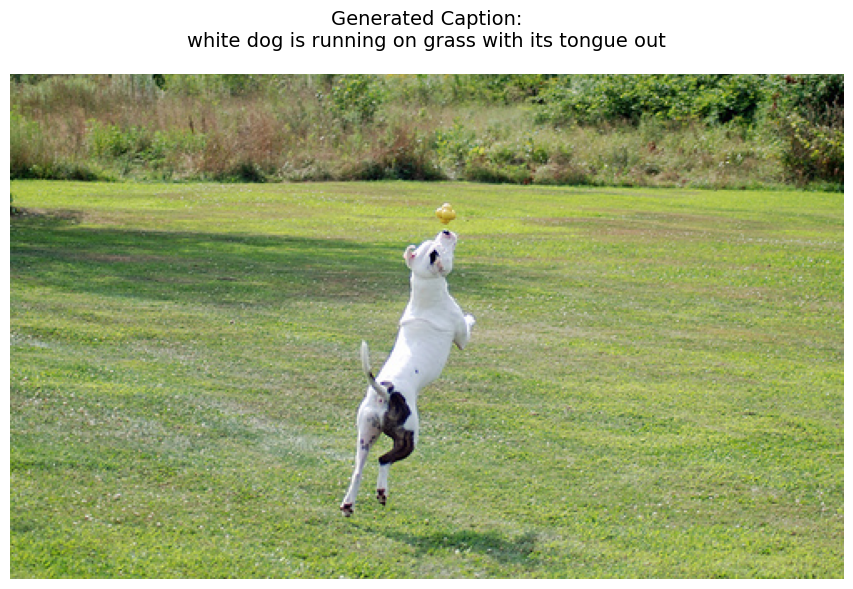

Generated Caption: white dog is running on grass with its tongue out


In [33]:
# Test on multiple images from your local directory

# LOCAL PATH: Update this to your test images directory
test_images_dir = r'path to dataset ...'

# FOR COLAB: Use this path instead
# test_images_dir = '/content/drive/MyDrive/Flickr8k/test_images'

# Test if directory exists
if os.path.exists(test_images_dir):
    test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Found {len(test_images)} test images\n")
    
    # Generate captions for first 5 images
    print(f"Testing with Model from Epoch 18")
    print(f"{'='*60}\n")
    
    for img_path in test_images[10:16]:
        print(f"\n{'='*60}")
        print(f"Image: {os.path.basename(img_path)}")
        print(f"{'='*60}")
        caption = predict_caption(img_path, display=True)
        print(f"Generated Caption: {caption}")
else:
    print(f"Test directory not found: {test_images_dir}")
    print("\nPlease update the 'test_images_dir' path above to point to:")
    print("  - Your Flickr8k images directory, or")
    print("  - Any directory containing test images (.jpg, .jpeg, .png)")
    print("\nExample:")
    print("  test_images_dir = r'C:\\Users\\jebar\\Pictures\\TestImages'")

## 13. Test with URL Image

Image downloaded from URL


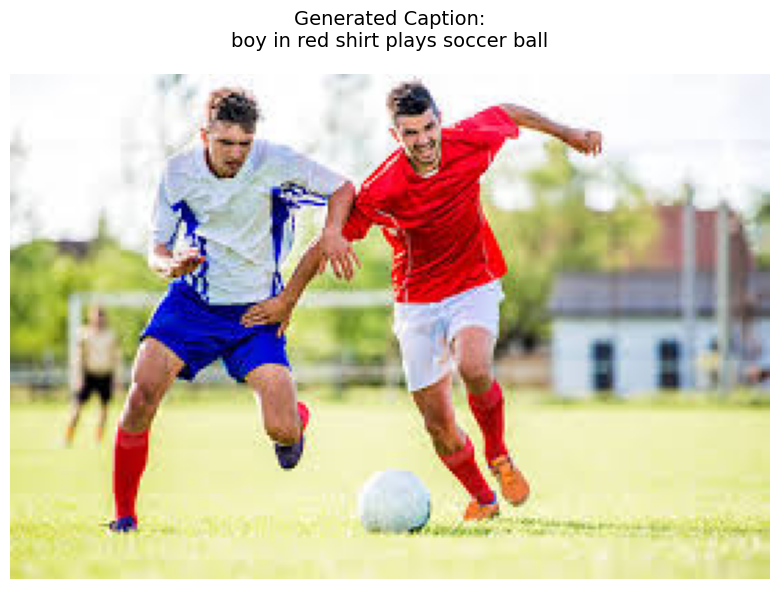


Generated Caption: boy in red shirt plays soccer ball
URL testing function ready!
Uncomment and modify the example to test with a URL


In [30]:
import urllib.request

def test_image_from_url(url, save_path='temp_image.jpg'):
    """Download and test an image from URL"""
    try:
        # Download image
        urllib.request.urlretrieve(url, save_path)
        print(f"Image downloaded from URL")
        
        # Generate caption
        caption = predict_caption(save_path, display=True)
        print(f"\nGenerated Caption: {caption}")
        return caption
    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
test_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFRUXFxcXFxUYFxcXGBUVFRUYFxUXFxcYHSggGBolHRUXITIhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGi0lICUtLS0uLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBEQACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAAAAQIDBAUGBwj/xABEEAACAQIEAwYCBwUHAgcBAAABAhEAAwQSITEFBkETIlFhcYEykQcUQqGxwfAjUnKS4RUzYoKy0fGiwiQlNHOTo8MW/8QAGwEAAgMBAQEAAAAAAAAAAAAAAAECAwQFBgf/xAA5EQACAgECAwUGBgEEAgMBAAAAAQIRAxIhBDFBBRNRYfAicYGRobEUMsHR4fFCBiNygjSSosLSM//aAAwDAQACEQMRAD8A7YBTEGBQAoCgYcUgBQAKAIfES2Xu700RZATBS63G6AwPXrT6kUupaYbEh9thSomnZAxHMNhDlz5iDBCjNl9QKg5xWxcsM2roXgeO2Lv93cVpBIIIYECJ2naR8xTUkyMoNFmKZAFAB0AQMWN821OxMYVABCCixUWGGQhdaQ0ZrmbnS3hibaDtLvRNQp0mM+w/KlZYoWrZQcI+lK02J7G8vZgnLmBDKrmANRuvmNNZqxQbItx5HSBUBB0ACKABQABQAKABQAKABQAVMQVABZaABloAJqAGiakAmgRKioEg4oAFAAoAOgBDGgBF8aRQA1iklYosVCB3LZywNDFKTaTJ44pySOA8/cYu2yqtlBYG4xQnvI7SBdlRnUrpk2GXrvVWKHU0Z51sik4Jx57V0lA1ppg5DlSIg5UjKBEGOpA21q98jPGVO0ejuUuJjEYW1cmSVEmANY10BMa6R5UhPmXNAgpoAh4pgTFAmBVjagCWDQM4D9J+FvJcZFZy7MWITtT3OmitlWTMyJOmsCq8bpuzRk3Sox/LvCsVevLbW0RbO7OrBUUby7idOgHtVzyqqspjicnyPR/J3EC9nsnJNyz3GJB7wHwNJ3lQPx608lXa6i0tK340X7OBvUBLfYyXGufsPZOW2Deby7qfzka+0jzqLmkdvhOwuIzLVP2V57v5fvRBwXP5uahFEfEhkMvvOo849qh3yXMjxfY+Thmk3afJ+P7euZd8P5usOYbuH1lfmNR7iKnGcZcmcyeCUS/VwRIMjxqRSHNAAoAFMAqBAoAFAAoAS5poBoimIKgB+3cknyqBIcoAFAAoAI0AM2zrQAMToJoAMMMsmgCn4zjzbt5wuYFskTBlgQCPHWNyB51VknpX0L+Hxa266K/kc94ry7ZcAXUt59sxgkLtlOswI0E9KqlNx8jTHHGRQ8Y5LRDbOHEroCCw08xmIEaRHlTjmd0yMuH8DtnL3DlsWLVtUClbaKQOhA1HzmtC5bmJ8yyNMQ2TFAFdiLTZwRtSELF2N6YWScI060AYrmwsly9eCNmRVGVYPaBm/ZsDGn2lI1gxrWbI92uR0cEaipLe/uua/bxKJOI4i9afJaNi4AIN4qygHdoQ6xrv4dRVMY1LY0NyceVE1OYzgEtyO3e4kF8wGiagxs3xn2Aq95qV1ZdwfZa4yUouenTT5c7+3IyvHea72IaTccLJhNlUTK6Awx1iYGw86j3r6nq+C7JxcPGlFN+PXz6Wvdb5le2KtsBnz5upAWPvJoUkzYsWSD9mq+P7D9jDhhmQOx2kA6mJCkgQG+/1qM9LVMy8S4yXdZKV/TzW50DEcgNlDW7omNriwwMbZ02+VL8LOPJ2eDfGRb3j8is+uY3h/wDeIwtz8S/tLfqY1T3ipRyzhtkQOOLL+V7mg4Nzwt0DMgnxB0j0j86vjliyp8LLmi54VzHavsFAdSSQMwESJ85Gx3FSU4t0iueCUVqLmplIKBBUACgAGgAiKYCCKYhEUARcFnB169arJFlFMARQAdAAIoAjKhJ3oAPEDQiaAKlsdGjnrsN4842/GpRhJisq+a+LlMFfcIDkQsFO3dgyfxoyYV3bst4ebWVUYvmTC2L7doySCZRgSrQwBXvLrsdhXNcmpOjeoxcUpDGE4dZu4i0LbOwQBj+1uMkIZOdSYJ16++1W4Y65qK68yGeUYQ1erNvhOIvnOUnSfvP+0V2pKPJnJvYs7HGnDd8yPCNfYiq5YYtbApu9yfZxXanumB1B0PyrNKDRaP3AZApCG8Ta2oE0PWLulBJGD5n5wtjLCBrJYobpEl1kdqbI3yrAOfYsqgSNayZcsX0PRcJ2Rk7uTb9ur0+Hhq83vUfC7pmUwGOZ71xhiC1sgf3YOq5YUgKuYqwk6EQWImqYtrYyJuXN+vIq+ZMMiLZQGQocax1IYtpoO8WXTbJHSlPn8zu/6fxx1ZL5ez/9igKqfhknxBI+Z2NQPQOGOT/202/FOvm+pM4Vwy5dcKGljlAXxLXFQa+rjWnFN8ivJP8ADrvMstt/s3+h3rlnhC4SwtlNTu7/AL7nc+mkDyArfjWlUfPe0ONlxmd5ZbLkl4L1z8y1WepqyzCZ/ieYMRMgzv4Hp6Vy+J1KfMsjyM9iORFuotzDuLLzqkfszrrAA7voND5b1dHh9cVKLNOPjZRVS39dSw5Y5bv2Llt7pXugEwTAlbqso8TJtmegHU1dixSi7l4Dz54Si4x9cv5Nj9YrVsYbHlBNAB5TSALLTALJRYCsulKwGmt1IBPZ+dAheHXrUCQ/QAKADNACC9AEO1dOYigQu9dCqx8BNNK3QN0Zi6x7RjE6nrH5VrW0StvcLEBHR0fVHUqykHUMpBnyiRUXKNbiUqdo51e5exiA4Y2frNofBczWwGSNJzsIcREbag1zMmCSlceR0IcTF89jT8o8E+q2czoFvXAM4kHIo2Ule6fMjSfGNdWGOjdmPiM3ePyLzB4cBe76knQn+lWPJKbtFNBXXVWAdgCdgTqdtl3PtT7xJbselsctn906gjyjc6+B0qyMk1sT82WmD4mw0cZvPr/WoSgnuia50SjfW5ORgcphhOqnwYdDVDHKLRgOb+ZlI7JCexPxQYbE+Sn7NjoX+1ssgGseTLq9mPL7/wAHrOx+yJQfeTXt9PCHm/GfhH/HnKnRguMY57zl3MtA9ABsqjooGgFUT57nq8GCGDFpgv3fjfmxvgGKwxYrdMLMgFGcDxACa6+Gg13pVdW6PKcZwGvI5YFabvT4N8/he43xu/avXB2QudmqhQCAJyliNB3UUZoCyT4kmm66fydPs/gu7g4zdtu2orbbpb8N/mRWvwIECN9ZA+Wk1G2uR13nSVKlX09eB076MuXyirjLjAtcUi2kfAM0Fm/xHLoOgnqdNGGLXtPmzxvb3aUskvw0eSe/m/D4X8zfksD61opo82QOJcRZOlZs+acegFb/AGgH9a58skpPckmN4PGXEYx8Ph5+VbuE1KJXLmX2HxTNGYECtqbCxu9dysPD8KHKmItsJfBG9TTsaJJNMYxdxABAmgB5TNABikMQxFSQhstQIawV0lZOlRGS0aaBiqACegBAWaACFsTQBW8wiLRA3JHyBH9KsxfmIT/KzI8Y5gw2HCveuqmaIWe8TMHujUAGZOwrVHFkkm4ptIrssExWkwWnaNFHp1PyqjUBMMKsnQRO+voPGm6SsKGEctBIgeG/zqrU5AVHOfEblrB37lrRktsQw0YHTXwNWYsijkjcU1Y1HUjm/BOKWMWLfb4sjEZk7t+3bNp7oZpLle+47MBQcyEHLFdCcE5vJCG3gm7Xu+/UaW1WbTCY3sM4GJVJYHJiLOKS2kgAoMTdGokEgttnI10IpfCTdaI/+rjJvz0p/BkrXUcu8xXm7idmsiRct3VvAgMynI6abqdd/IHbDxcpYWsfXnya26bPr6Vmvg8McjcpclsUXEeYmwue0pk3rTqxJjLJWX13aCwHm3rXOeRpM9FwuCGXJBS/xer3V+7oy+I4iXJuXGLMTqx7xMCANB0EDptVKm7PV4p4sOPSuS8N/sQbuPLSANaT8WZ58c5XGCpgzmN5B6DefAwNaV9CWubVt2n0XP3bITfZtJ0B0Cjr5BRTSZXmlkSWrZdF1fwX67eIdoaAnp0GwPl0Lfr1HSCC2t9Oi6fo39vq+18gMFwlgfxT5EuxI286swyqVM8T21b4yba8PsjdELE10DklRxu2CJrPnS02NFSuGtgTWaChVgyvuYiDp40LMk6Qqs22DRSBXSS2AhcQKBsvUiqcsktmFEGy3Zv8WhrPCThOm9iSiS14oJImY38q1LIDiypxvEluOmRtcwE+u9KMtUrRGSaRp7DgDerhCcHjkckAyRoaBjHEL2XWYpN0RZnbnMxBI7unnUO9I7mmZWy6af7VMsJWFuSIoGPzQA1iLkCgCFwjGZwT5neoQnqViJqtrUwIHGYgHpED1J1/D76txcyM+Ry3nvltMRmFmyr4u6mVWJC5Usstx210kgBJ0PfA2mujh4qUEoyl7F/V+rKlHchfRRxp7llrVxnHZQFbKT3CO6A2ozaEQekVLtDhO4erkmRT3NopdhqT7xPzrjapMsdEu25OnzJ6R1NTTYqKXnO3nwGK1gCy5k/4RMepiPep8OlLLHVysnyVGB+h/hBLPiHVGslrVkK4BzXHvWkLCdBlW63rngTXT42SSUIvem7Xgk39Qhz3O52lVcqLCooyqq6AKBooA2HlXn5ZG8ntMsMjzMc2MJA0t20tz83/AP0PyqGTeXwOnwyrHfizkfHbhuYlnGkd1fbf79CPKszmqo9FwXCTX+7yfT3eua9w7hcDcdDc7B3tklSVRiJUSYZdVjz08ZqMXXSzXnzYpy0TyaJeXX+PqRb3DQALlrvKSQVY95GHQsAJBGoMDqOlNzTQ8XC5IzaVS6rmtvL3dfh4jNy8yDdUnoDJ9qcd+Rdlzzwqm1HyT39etuYxbHWd/MyfIsdh5CpN+Bmgk/ab5+e78nLovJb/AHH1u7AbDyj5DoKrlua4ZKpLp6+X9s6f9HXF1ez2BIzCWXzCwp+7If5qry7U0ec7Z4WSX4hcrr57r9V8jY3Ma4WAxoXEZEqs860itxPEHI1M1CWWctmyIhLsrvUU2iajZXXrkGluJqiZh+I3UjLcIHhofxrRDipxVWLYH9pFiS7EtVWXLOTtj2RIW8X1JNV943zJxZR8ZtsDM10cEtSNMKaFcMH7Nj1rbj2RTnStDK8YxBIQ3WiYjTb5Um2T7uFXRYnEPZcOrQI7w/epttcjNGKdlnjeJPdsZlBJIHe6a9R41CTbVFElTMhc5fYkkzJrLbXQDpuP5gsr3c0mNgJ/4rTk4iEObJWVmF5mgaWyR1giazR45N8gRBvc/otwg2rkD+GflNb4SjJWS0gu89pdUi2jT/igfgTUMs1FBQ5wLibqACND1rFDiFF0KjXDErl3repJrYRT8fxYS2rMWAJOxP8ApG/5VZjyRgrkSWKWTaJScsB8RcxF7VFCdlZkCQWAY3I11mND0VdtZ0ZnGOlPfq/Mpit2Z7AG7w17eFsWRcs3cUU/aobb960hZ7d2ALgBS8TIP2QOk7uIyLiv92T9pLx25vp06C06dqNrbxNvXN3CN52/m9+sVznJLnsFIVdtSOgXrruekmoyjfuAp+bMMt3B37Q2a0+vUsFJU+kgHzip4NPexXSxvZWZ76JcIRg8PpIuXnf0CMDJ9DYn1itvaa0ZJLwS+v8AZCLepG64zxFLINy4YAnKJEuQNgDv0+Y2EkebauWp8kbcOJ5HSMnaxheWMDMzHT/ESTB96FKzqqNRpGaw/IhuO+XEKqBljuln17xkAgAj11ms+SoM6WbtruoxuLv5LavXkdEtcIt/V/q4ns+z7PpMEQW/invetUrfZHnfxeR8T+J/yu/L3e6tjlXNn1hHW1fykWhlzwe/bcZQxP29BodwQ1Wwyf4s9fHBhzYnxHD8pc14Pr7ue/St/Axt1SjsASIYj5Ej8q0OjJico7pi1bz/ADJ8v6VFo1Rl4v8AV+vId1mOv4f16VGi72r0rm/p/PTwv5l7wbEmy1u6n2GPvEZhPgQxHvWfJ4nSWCHEYJcO+TVfz89zrNu6HUMpkMAQfIiRVNnzbJCWObhPmm0/eisxLFTB6mrIojQsSFmrWkWPZFTfzM4iouqKpSLrD2BGtZ+okiHbt9871e42iagXCsoWar0WyaiUvEr010MEaRphEVw7+7at0ORRxC3RUWz3x6/nUC5r2SVzTfZQoUxI1qTRjg/aZO5Txhezl17vyEUtVFWSG5eKB1rM5qw0oxgV0Mb+PnXOlJSK3ZdYRjoAN6qU1EnEkY7gluJ+0evnVi4pxrctIPDuBZDPidall4zUFGltqAIqjvUxDNxCuqsR70oZJwezItFn22Hu2UW+QpkiSYhidBPnpXYw54zgtT3LcTlHeJnuLcUscPtMto9o2btBbLv9sRMhYKECdTv905ZFDZczTGDm9UtvkYPiHGcReVL+IsIy279nsiko/bEyAhX4iJMzMwvnW/sxznJuO0a9p1drwW23v+ZXxc4KLjK7rbfl5v8ARHTIzCHA10kDQ+vhr0FXZYKW3Q5abFpmQQoDD91tAB5dR8orNJOO0dycfMdu2M4IJIzAjWJ1EaQek1ZjdPUN78hrk7CJhsBYllAWyGJ6AEF7je5JPp61V2pxbzZm+rfL14E8cdkYDmXjjXnLmTrltp1CnRRA6nc+Zrl5JN7I7OGKxxosrHCX7O2Q/wDeu6gmYVxGTrszK+vQRFKN0T71RnKPgr/f9CbwS5mBK7hhmGxK3BOoHVGBWfCfCqcrWnf1XqijjKqm/c/Br9yzfipXSKzYpM5OujG89cQBnLlz3EVZC5rgUkiATpbBzdBmOo2rTDmex7GT/CJtySt8nS5pfF/Rc1vywnEbDG44mBmbU6CZ19dZ2mr9STNUcWWcFey89l9rfwGLSfu/zHT+UdPXfyob8SzHDa8fze3/AKrdr37tdEO2kjbU9T+Q8BVcpWacWJwXi+r/AGLLDIwQgxGZT17sggz6wPlUZ7x2N3D4njy7tbr48/7N/wAkcSmwbZ3RoH8Ld4ffP3VlezPIf6l4dYuKWRf5r6rb7UXWKUO1WJnA1EXH38oy1ZFORGUikbEka1Z3Misn8NxsnvGovC/AnF7lguKtiRNOOObZojJWRGx67TVywO7JakmRr15T1rRCDRYsiQ/w9hkatMImfPNNoprb/tB/FUNJd3qolc2H4PSmzLje7KfhOOa0GymKhOLcdiU60lonH2I3NZO5mUFohUya5DbQExbgABFVNgRsTxIlwo+78Kisbk9iWosMA7FoIMVasE3zTHZZXz0AqbxSvZDtES/Yc7A0liyXyItjdu+6dDO20/MbGroLLF2kJSpnNufuPLbxFy32QNz9nnd7lw6q2bIUmBoApG8MRO0e87K7Hw9xHPxG8pLqlSted/C17qKp8RllcYul66oRZ4omIL4m2oHZ4nDfV8Mz/A14j6wFQfZdgxmNJJEGZt7iUFoi3+V6q8uXVdOn3KZN3udWEbNPh3ifxG3vFch0+Y0yQl6N9fQz+Jo3RJFXzfiimDvuFkrauEE+OQgaeEmrcGLvcsVXUndIzrY8W8H9UQMAHbeYFpmF1bamTmCtcNs/+0ehrm9pqMc6knvSv38vrz93M38Fj1LW/gHytwDORirilhJ7JTsSNDcM76ggehPhXJnr/wAUT4nNpemJfY7Cl07M2yU00GmUqZUqRsRA2qMYZV0MUZuMtSE4DBlGdgjS5kzrAJJgeUlj/mpSx5ZqqJzzynFJ9A8RgrjHRTUI4Mi6FDVmX5n4SUZGYbtMAMGdyoFtc+o3TpECTOorTCDUlqR7TsXiX+DeOrr3bLU22lz/AMufu8GzAsmYkmB47tv0k7+lPWzr/h4y8El/2+Fvn7txzsfAR5kkmPf4ai23zNCwLoq9+7r9CfwzhF6+Ys22Kg/HoFzfxNp7b1biwTyP2VfrxM/E8dg4f889KXzb8lu/obngHILKc1+7oQQyICxYHoxI7vy0IG0VuxdnSTub+X7nC4z/AFJj06cEG3z1S239y/jwFYvCrhrrW0XKoII3OYMAZk6ncifKuXxOJY8rijznE8Zm4qfeZZW/ovcuS9WLt40nWaqM9i8M3aSTW/hce4xF3CLXUUEIaGFHQ0d2vALGUw+p1pKC8CVhjCjxqehEdTC+redGlBqZOwVqEb3ppEZMr1w4zr60nEaY5zSklPSqGThzKbCWe6SfGrIVQ5XY6AtPYjQ7hsSR3DvP6NeYmtrIGhwluEmsuRdSaRL4XhEa6D1itfZjvK0/AUlsWVtwLjgD4fzroyyf7rikTx49QzhuNo6ZgJFRycSoOmhTjTHhxpY1EULjIeBEpeauaRhsMbqgG65yWgdRmiWcjqqAg+pUV2uweGXaGfdexHdv7L4/YryyUYnB8dcd2Z3JZmMszSSxO5JOpr3maC/LW1cq6GeDVbB8Ox1yw5e00EqVPjlO4B3B0BBGoIkVzM3DancN/J/zvXk/gWbPZm/H0v3OuEX/AORp+9Sa4z4N3T2fmtwUPMlcK+kzF33yWsNZU7s7doyoo3LAEfiKo4iEcENUpfDk/qy7FilOVIu8Txhr6ZL7o6HcKuW27dQRJzQfs5mFcafHZLuO33+f7UdTHwmNc9yBYt9vfSzahVPxGNERRJy+Gkx5xXPnku5SL8k1CNrodKtXkRQirlVQFVRsFAgCrFxkFyRyHbdsh4zjSp9k0/x0HtREjLzMn7pqT4xLoRsGI5gjUIah+NTfIVhtwpMalu+7XENu4coUjKdF1ZSNT56Vrwwjm9p7UdLhe0MnDY5Qik1Lx5/Roor30dWFj9rcHgO6T/Srl2bB/wCT+h03/qjiK/8A5x/+X7kvhnJ2FtksqNd1ABvZWC+YUAAnbf8A51YuCw43dX7zn8X27xfEx0tqP/G1+rNHZtADuiRtOgH+UAQB6VqvpyOXu3qfPxJNoUmRZheMYhrty4XPwMyLGwVWIH+/vXmeJnKWV6umxOK2M9ZvsSQDpTUE0MusJjVVI1mulwyjFbiYd/Hr51stERCY1Y60WgGBxBQToaSkrJPkBOJL4GpaokRI4ks7GhyiG5Y8OxqsjQNpotPkJlYvElN0LB3ik5RoaJ3M94DKY6VmZbjMqOJ7oRpREskx4YtPA1dcSq2X9nhM97r0rx0uIp0LSWVsFF1ql5NRJITyrcJxTa6Za63ZySkRkaPGcKhnuK5lhEdNPAe9bZYvbcjThqJS4TAPaQljWficTftEcjtkbiLDJoQJ2JMAeZJ0A86xQi3NRXUokcw5v42btxQBNu2uW28EC4MxLXBI1DH7gvhX1LsXDg4Xhe7xSUpXcq3p+Hw5GTLCU3ctkZt72beulqjLb7oShp5BFPMe/wDWiWNJXf1/cakELc+B95/CqoxjkVKpL3/xQ7oteB8Y+rBgbYZWMwdDmAgakHYFtgDJ36HmdpdlYsyjOUtFeO/yXj6o04OJeO1V2OY3mq+5DBLasJ7/AH3eIiM1xiQPIRWCX+nscoqUdVebX/5TLvx0/L18Tqn0Y4MFWuvcD3FRVaI+K6q3emwCkLpuQ015Hj8Pdyqmou6vrTr7l+TJcVC7fNm1+rTrXPjibM1FHzBYKqYFDjTIyM7hlMjTbWoyZUW/1lSACKSi7HZruXrls2iNyDLDw0hfnH3Gu9wH5KXOy1jOOukHRdOp3rqJsr2KpbrtctyT32y+2p0Hop+dXWoqmVJOTvoT8bxVV0VQ3+I7eGkdKw5OJ0vY6OHhXNW3QeD4mGMMuXzB09/Cp4uI1cyvPw2hWmco49xrLeugEkm5c9+8da5nd6ptvxf3K62RAwfElkLOp3qM8clyFRvuVMFbeZBJ86s4bVJuyMjQvwK0fs10NCK9xpuDWRuBRoFYxa4JaJMAGnooLHP7BtfuijQhDT8IsDcCnoFYRwFtR3AINSUaHYP7HtCGIA86Tgguir45ZUuAdoqqMbdFqlRV8N4QhZiR1P404RVk5t0Xf9k2v3BV+hGa2U1jjSgb142fBts1KRLt4oXAZNSxcG3YORK5URO37v7prdwcXGW4uZe4Zz21xZJg9fQaVpi3rZpaVCOL96FJgGlmt7Citinw1i1fudk4zooY3FOxRR8J8m0X3rHw2NrMmUqKk6I/Grdq8zW3tqbcmFjRRsMvhA6iunDNPFkU8bprw9fQ6Txpw0vc5fzZyucNFy2S9ltm+0hOwePuP6Pruzu1sfFru8qrJ76vzXn5fLwOVn4Z491yMuH16/Oau/ELVVyv/lf0ZRQp7bRnCkCcubWC0THrFUZssXL2F7Xrov3+KHHwbF2rGxOp+4V0OF4OG05+1P6L+vqyuU3y6Dziu1pTjTK4s6f9Dl9RbvqPizoTqYy5TEDoZnXrI8K8J/q/A7wv/GpL47fp0NGCW7R0X6/lMGK8d+V0jTZE4lxK2wjepxx6ugmyouX7aMJpZcFKypPcO9xKzIE6npFVRxSZPYmct3CuJ65XRhHSRDD/AEn5mupwnsyLJGhxdyuvHkUvmVuIw7FQRKtByEeLAgEfzVTnateP8F2Hk10KzG90W1gDKijKNhAAjSsEtqR1MXJ+8TdxvZ2rjr8SozL/ABBTl++pwlsU8TyMFwLgpaWuSZGhI61JSSMWhsatcsn6wX1y0PJEaxM6JyrYCEwD03q7DRRljRq2eryqzln0gcYv274FtiBr0q2qiVrduzTchYx3sBn1alJbWNbM0zXKjRI5Rz/xK+mIARiBB2qcnpqiEI6rsvuT8ZcfDqXknTepSqrBXdGi43hLly2AjZTodqx5OIjFNF0cTbTKLitlyy+KjX3qWJrmD2ZDsYpgYA1k1ZXgTT23NLZZso0q+jPZkRwhADLf9NcpwRemyTh8NbBHeOvSPDrSjjqx6i/5dw6LdlCdv+ahGFMlF7mV5l50+o410YSGAPpUe6ct0aHKtmOcA53XGYgWwNAJJqLxSW7EpXyNHdupatXmX4nZE9AczH/QKnSirXMlw0bmZ67idyDVL2Oi+RWcxXsScLFiy10uCjZRmypGvd+0SPLr6TZwsVLJqbqvOt+m5m4nKoQ09WU3I/Ji3l7bFB1UGFtfCXjdn6hZ0gQSQff0XEdoNY4whzrd+vW5ydPM2nG+AWb2FexbUKcv7MbKrrqvoOnuawcLxHc5dcnd8+pGcNVVzRzPhPA3fEHD3f2Trq4aMwUQe6J73xToes9K7eTtuHDY9cVqb2S6fF+C38728x4sDy5NN7dTp3COXsFbTL2COY1a4odmManvCB7ACvP5e2OMzPU8jXlF6Uvgv1t+J1ocJiiqS/UtOA8Iw1u8XtItpipDBZCsu8FZgEEAz6jrSnxubPi7vLJyXNXu0/fz5WU8Rw8Y+1FUaC4lsjWsDjBOzNRXY9LIG1WwcSJn8desneZ8J/rUZSi9iVIi27tgkTMyOv8AWorSg2s1WAxlq3dtH/EF3/fBU/cTVsGk0xSZaXBJI8zXSq0QT3G8Ti0tsqmDcIAVeoHifAVmz5Iwl5mrBilOL8DGc2cRZb4uHS3cHdPQFfiX7wfesGWXtG3h5pRob4XxK3ckFjGUyToDAn9elSxTV0wzxc1UeZoLFu2IERQ3GzIrodui2KG4grH+EMuYxWrAUZky8atJQcu+kLiC27yypO+0VZ0KabkX/wBH1/NYn1/Gh8kyVUzUMaQzl3P3EQl8DKTofCie1ChHU2XPKGODYdSBH/NSauIuTNFxbiLW7YYCdq52TErs1RkQrmKkFvL8qui6ohVtlNf4qiKSFJYCacskk9i6GOLi7IeH41jGUMLcA9CavU5tcip4oLqanEcMVkO8x415xZ2upp2KH+wIKnv/ADP4VY+M2og0i7wuGNoZkBLQd/TrTw5dUx0uhzF+X8RxPG3nuqVVZAPSRoAK15uIjiSS3Y5Jye4v6NuAXExd4OpyoSubxIn8oqHEcTFRVdRQ9lm55iuDD2Pq6zmxDdox65VOVAPcMfeljk3C31+xr4aCbcjJ8FtXLzi2B3pgfPc+QEmqshfrpNvodFw/DFVMoBMaT4+dZZ5aexzZycnqYjD8HGYkhqf4hiJKcHA2Bo76RGgPwNCcxWT9/hvTeWT2JJ07RU8awn1e7lUypVWWfBvHz0itdLZrqjpYZ642RuHXv2i+Zg+h0qUHvQ8quLNTguFJkBVs6nYggg+hGlZJJrmc6UZQemSp+ZD4rw3MICGoQyOLKpCMDyxZy95J9abk5OySJH/8jhswbsxNOLd8w2FY3lu08HLqpBB8CNqunJqqYqTM5zZxzEpiGtBhbUwwZBDMrCfiaSNZErGq1c+MyyVJ17jZg4bG0pPchcsYqb0NqTrJMknxJO9QxbumdCa/23Ra88YRVwTQs5HUiP8AEcn/AHCqFPUqMPZ+Pvs3d3Vp/NbnNsLitCo66Hxjeroc7O9wXDRx5FOTtrl4HTeULS4nC23JJKlkJ8chgHz0K61Xk/PscftWKhxUtPJ0/nz+tl3f4Mka0HP1sZw1tbR0qzDxKg9yE5aixsY5W8a1fjYeJUomT5w5cTEMGIYx4VXPtB8kCxpMm8t4MWEFsSB86sxcfHTUhShbNCQIolx66D7tGW41y1ZxD5mGtZsnHyb2ZKMEibwvgNqzbCLtU4doy002J4k2ScdggQASSKjLjbHpIi4VTM6Coz4q1SHFEW/hrCGTEnaoY+JkuYMWt22BAitS7RdFbgmzYphV8K5axovDOFXwp91FgMcSZLVpmI2G3j5VbjjGDsnBWxvhGBVbQJADES3qdTUIRUnrYpO2Q+CYZB2zwAC7GfIDU/caHBSlROS1SUUc4564j2+KOT4UlEOvwqa2zpLSuS2NMFpiaP6NOHSXvNBVR2aebMAWb2ED/MayN6tiHET2UTfrh18KehGQWLA8Kl3cRCuyFPQgB2Qo0IDI88WwLlo+KMv8rT/3VZapG7hHs0Zq0pUiDqGHvTi9zTNbM0f0cq3/AIgfYDiB0z94kjwJXLI9KnkcW9i7tjNHNjw5P8mnfuW33uvibTsx4VXpRwgdmPCnoQA7MUtCASbYpOKAx/0jcHV7HbDRrX/UjkKQfQkH5+NRjFWaOHk1LT4nNOCYpkvrIPl+VPVp3Ori32Z2W9g7eJwuR/hu28rEdCV1PqDr7VHJFXZyYyeHNqjzTPPfF8LcsXnsuSGRirecHcHqDoR5Gpxdqz1WuOSpx5Pc7N9Fij6gvlcuD7wfzqDW5xO2Y1xP/VfqbHsQaehHJCOFXwpPFEAhhEHSl3MPAAzhl8KfdRAL6qvhUe6iADhl8KfdRAScGnhUe5iAX1NPCl3MQCbCL4UPFEBpsAnhUe6iAzd4TaO6iovEgG/7Itfuil3aAsAakmMWtTjuwIPFbOcovTMCfaocRC0qZbiyKKfmTHHdIHhUktqIRdNNmf4/d+r4C+Zg9mwnzfu/91HDqpO/P9jfwKjl4yDfK7+W5xy7iG6sp8CddPnrWhpM9BPgsUpXp+/7nW/o4/8AQ2zvma4SfE9oyz8lHyrM37TOB2qlHiXGKpJL7GrU1NSOaKzU7EHNSsATRYFHzdwj6zYIVslxJdGO0x3lbQmCPDqB6UmtWxbiyaGccTjgDKmdG2+FwTrv3fiHjBA22FW/h8t6dP7fM1/iY0db+ju9nwYeAM128dPtftWEn5Af5RU82Pu56fdfvasyZp65X06evN7/ABNQKiVB0rAE07ASaiBFx2FS4jW7gzI4KsPEHz6HzqtsabTtHEbmG7HEvYYmbdwhS3ltHqNfOoS5HWwZUzYct8zqhVC3dLhHH7og9/yg5Z8qvi9cNPVFkuC/EapQ5pX8fD49Cl+mPAKt+1dAhnQhvM2yACfZo9qqg96NPYz14ZJ/4v7/ANGs+it1OCAB1W4+YeBaCPuj5U2tzJ25FriE+jiq+ptBU0zjCpp2AKACpACiwCJosAqiAVACSajYBUAEaTGJikAlQKoVcwFCKna6AKFPcAiaVgZL6TH/APL7vrbH/wBi1LC/afuOp2P/AOUvcziKVoZ6uO53/krCm1gsOhEHswxHhnJfX+ast7s8b2hkU+Jm1418ti/U1YmYhQNTTAOgA5osBJFAjz9xrlK9ax72LOGuOGc9kyo2Xs2+A5x3QADBJOmUzXZhxGPu1Nvfquti6nc+XuFjDYe1YBnIsE7ZmJLO3uxY+9cucnkk5PqMshUQDpgFSADU3CS5phY21VsDnn0k8uZpxaAnKP2wG8KIFweg0PkAehqK57nS4CWOT0ZFv03r4fsc0vcQAkIN5lvX8ast9D0+DTBrovI6Pz/hlxljCYpCwQmGIGbKtwTJA8GQqT4mq1qVtK66WlfzOHwOT8LkyYJ/D4funa/kXySEw1xcoK2royku2Ziygsr6d1QQGB9RTxzU7jLn62H2i8mfHHy5fE6IKZwRU1OwADUbAMVJNAEaQBUdAE1DkAKYBTUbYCTSewCHNQkxgzUtQCBVSAUKlQCqnvQBCkm+oGQ+lIf+Af8Ajt/6qnjftevI63Y3/k/9X+hynlDAC/jLFthKm4Mw8VXvMPkpq7I6id/iMjw4ZzXRbe/p9T0KtZk2zxQ4tWxAWKa8wBFABgVKmwBFKhBhalpAOKbTAFFMBS61OKcnSAVeOUQPc10cWJQRXKREuOOtaEVgtHp8qy8Tw6mtUVv9yUJ06YopXK02XHH/AKReTxhz9YsrFlj30G1pztA6IT8jpsRTi31PTdm8b3y7uf5l9V+/9+JM+jXi6Mj4LER2TyUzHKJ0zJM9dx5g+NSljcuRLtfhrguJx847P3dH8OT8vcTMbg+yc2gB3GIB1AA3EKNBv7aVzskWsrkQ4SWvBH11NhytjzctlG3twAfFTOX5QR8q2Y5akcnj8CxzTXUu5qy7MACKKAFC5ACnzATUN1uAUmo22gBFSStgJM1F6nyAQxNQeoAp8qLdcgE6+FR3fQLHFOsUR50xgB/XjRb3QADHwmoapvomAsVcmBm+fsPnwOIB6IG91dW/KjGnr+B0eyZNcXD4r5pnOvonsg40kxK23K+phdPZmqzPskdvtZyXCP8A5I7Ss+1QVnkxYNNOqsA6e/QBVT1XswBFFAHFOmhAzUatrAP5UJ2uYAn9elClateqAVaOs+tX4Hc76CfIiG8D18a36ikauXR71NSIshY7F5UZpAyqx12BAJ18qnF0VzZb29QCdNB7EiuHszaVXNGIVLLKwVs/cCmYII1n2B9wKhlyKC1Lf1/Zt4DC8mZO6rezkycAC3WuG7kthswGWTBMhQS2gnQHXarOG4uEXGUottb+Cv6v37HbzZprHLGmknat77Pntt08+e7OmcR4T9btJftFVuOiMSZKnQfu9RMTrMD1qqeNS3SOFh4qWF1F2tyx4HwgWEKlszMZZtgT0A8AKlpX5SnNmlllqkWmSKlpSKgRrT6gEaTbQAB60k1zABob3GJijS2AQpLdbCGyPWq9ufQAEDafOh09hhsP1+t6k0mAkWh40lii1zYEPtm3j/cfrX5VzXOVW/V+mSFpePl5j08+lSWZ+QqFrcPT7/PxqxTfJBQYc9R/SnHUluvX7gUHNuHxlyyVsFCrBwyxDEkDJqxbu/Ee7BkDzrocBkwxanl5X/dr7EoZJY3qg6fQyHI/JeKw2KF+7srumUH4hlZQ0zqpkHoRrW3tLjuHzYtEFvtVKvevX7lkOImozUm3qSW7vk7s6gLhGwmB0j5b71xE2t109fP+fApDtXSd1I/PSrVKTW69UvX7CHJnTX2/X6inH247IAlJj9a6VGN1v/f9ALJMiOv4flU3qT25+tgBH69/6Uqabv1uAcmmtV16/oAK5On3xuNqFKb2AAovqn7gBcmInef9tqs1Tg1K/MTKO4bwuQLbFddRERv6nb761fi1qor0Mj30vkiEO0z0EefSrVxcKuyt422VNkYm+0PhmSyJJDkFrsPlCADRQdyST3Y8ahl45aWsat8r9erIdw27ZqG4m+Yjs2IBIkgjYCemo16fjXK7yT6GrUR7mIW6R2llmC/DI2zaEmOp3joBTlNSdNXXIsx8Rkx3obVjGHsWmYD6sdy8kCFKkGSfLSANPKiFt2l/Hq6Ceec/zNlolsyFAcCDrPdGkZY6HWBp06VPTKyAgqysSXuwZ0EHeR08P1J1qNyXiKhdprhg5iBvBTppPXfT76mnKrsNxDPfnuspB6FSI00mPGlqnaYbji3rh/cHe312g9IEHak5PmG4rtXH7s+466DX8aE5dBiRfYz8MdNTvPhHpRu022FjNrEXDG3mcw022qC1PkwtjrYhp8/WJ8dTScpaqvcY0bzSAAdQOuk66z+t/aotS/Kn0CxBxLDUKT4aj5e0x40LXewWH9aJBORvunTymN5o9p8kFiBiGPj93Sq3CUt3L6BY6W3gfrz86jKbd0OhwiRt/wA1ZNJx5CFEfrp51KT6UAu0pqeO0qAUy/j91TaVUgDy6e802vZpcwFKBpTiuQC1FWJU7AMg6UNNVuAsGpqW2wBZaNCoQUVGk0MAppb7iDijSAZFPTWwBGikAWWouFgHHnTqlzACNSg/EYc09qAAApxUaoBLxUZ0hADCkppDCLUnJ3bEGblNz8RhN47U2r35CFKs1OEXLcBvrVbVPYBKrSjC+QCYGwAqLpOqAWUB9amoqXIBCDcwP1rShFrUxjJdRAHvVOtQ2QCjdAJJ6iIq1zUfafUBsFPCq/YAbsPrqKzYZJNpobHHPhUskUuQC7RmiHmAd0HpUsql0AJGNRjJvmIdNqr1jvewFdlpU3i22AApRe+4Ciam3aAIGq1KmAEB3qyOrmAJqCkuYAVjQptgKG9CbuwFzIrRdqgCyVHTvQBsKc1XIBNVpgBRUkgCZKjKABxQ1SASq0ooAU9gDmm3aAOKkqoBEVDqAtDpU8bdANMdag3uAM1JzoBIFLagGzcIqtTadIA1O9ThPxAatpvT2GN3gKpnQhsKKgtIH//Z"
test_image_from_url(test_url)

print("URL testing function ready!")
print("Uncomment and modify the example to test with a URL")